In [221]:
import pandas as pd
import numpy as np
import plotly.express as px 
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import tree
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

## Veri Setini Okuma

In [7]:
#Veri setini okuma
data=pd.read_csv("C:/Users/tgbnr/Downloads/heart_failure_clinical_records.csv")

In [8]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [9]:
#Boş değerleri kontrol etme
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

## Aykırı Değer Analizi

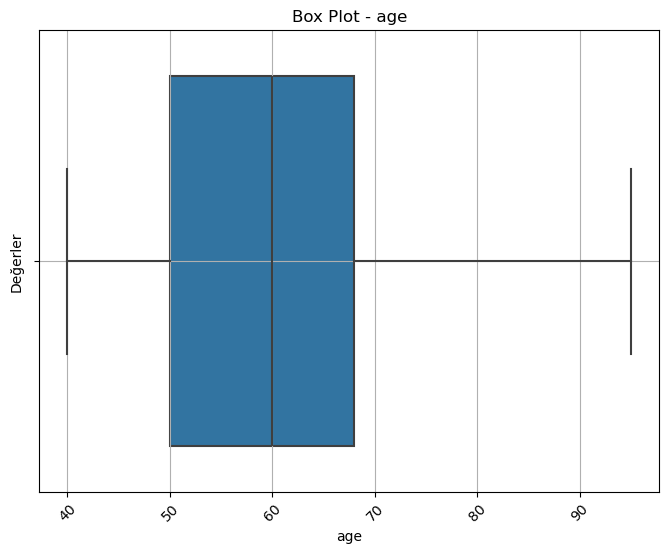

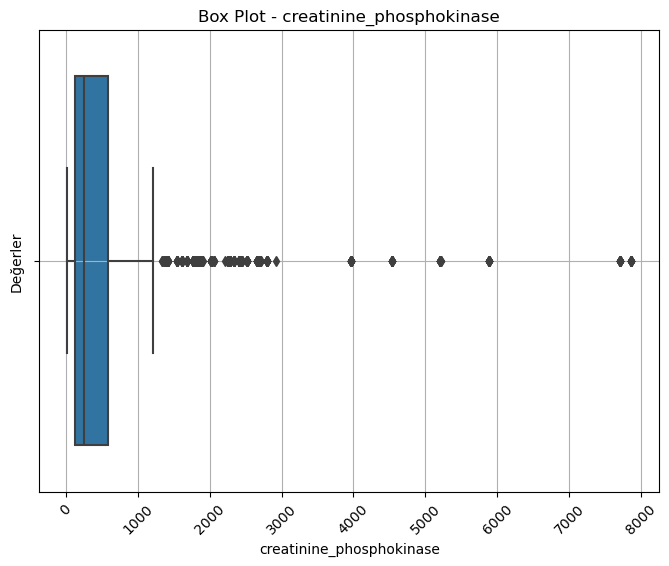

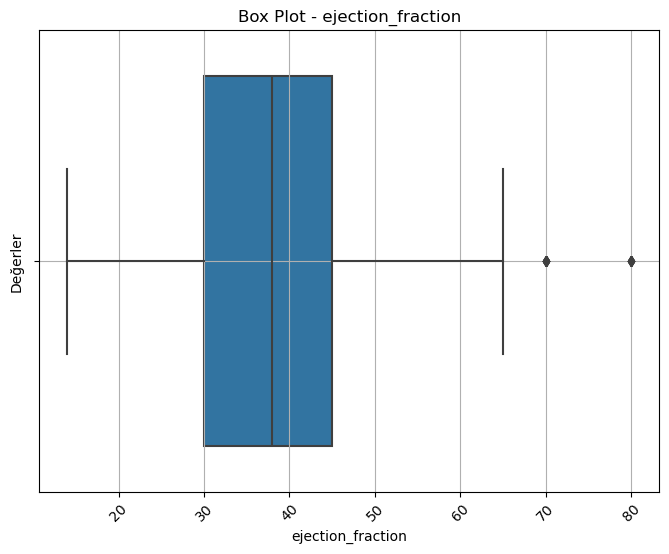

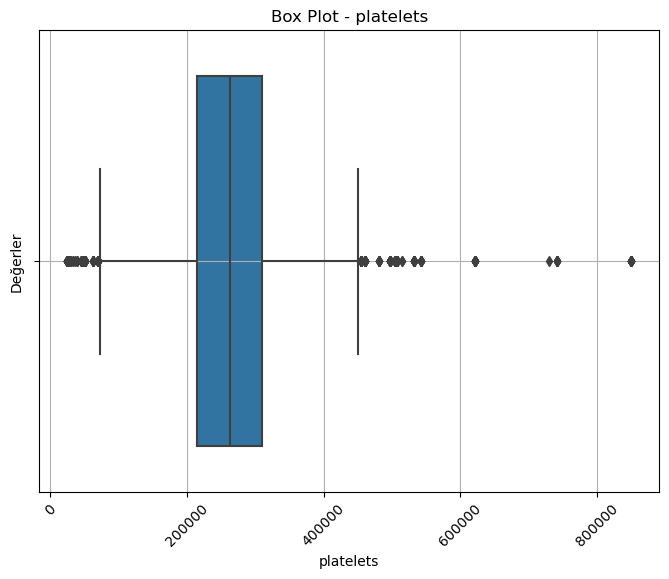

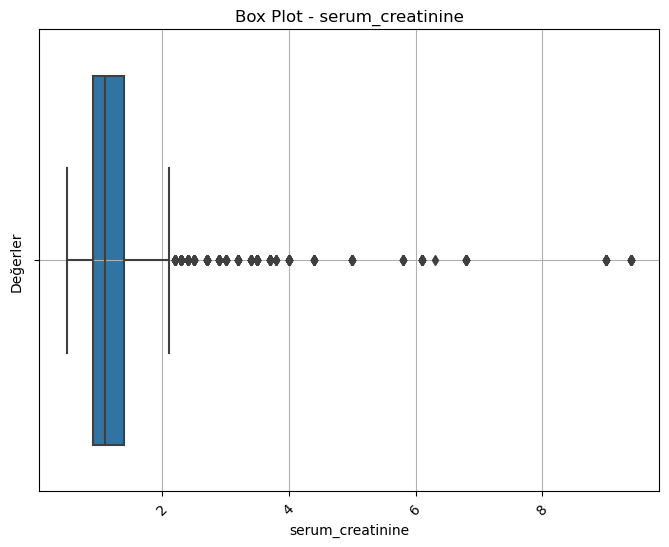

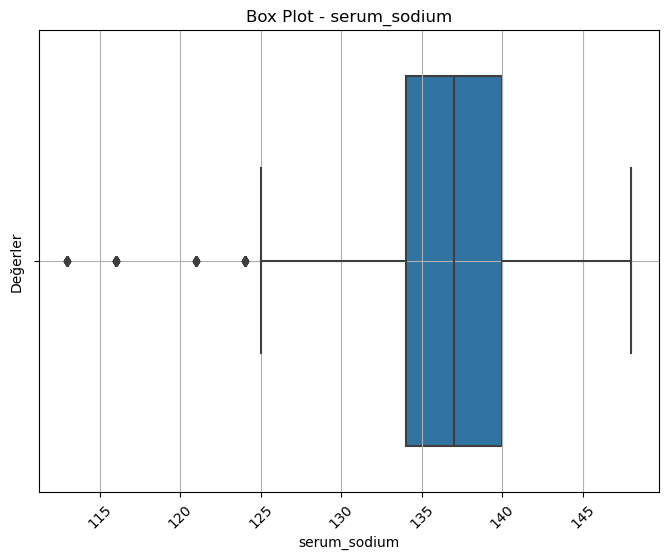

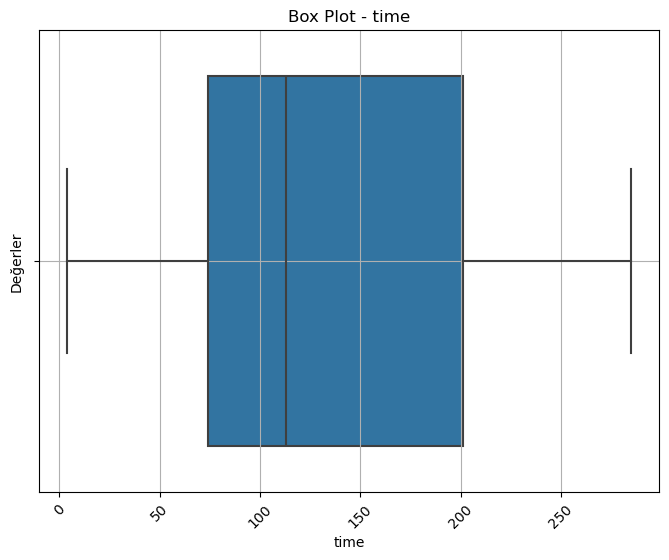

In [10]:
#Sayısal değerler için aykırı değer analizi
num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
            'platelets', 'serum_creatinine', 'serum_sodium', 'time']
for column in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot - {column}')
    plt.xlabel(column)
    plt.ylabel('Değerler')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [249]:
outlier_cols = ['creatinine_phosphokinase', 'ejection_fraction',
                'platelets', 'serum_creatinine', 'serum_sodium']
outlier_list = []

for i in outlier_cols:
    Q1 = data[i].quantile(0.25)
    Q3 =data[i].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = IQR * 1.5
    index_list = data[(data[i] < (Q1 - outlier_step)) | (data[i] > (Q3 + outlier_step))].index
    outlier_list.extend(index_list)
    
outlier_list = Counter(outlier_list)
outlier_list = list(outlier_list.items())
multi_outlier_indexes = [key for key, value in outlier_list if value > 1]

print(f"Aykırı değerlerin olduğu satırların sayısı: {len(outlier_list)}")
print(f"Birden fazla değişkende aykırı değere sahip satırların sayısı :{len(multi_outlier_indexes)}")

Aykırı değerlerin olduğu satırların sayısı: 1129
Birden fazla değişkende aykırı değere sahip satırların sayısı :77


In [250]:
#Aykırı değerlerin olduğu satırları silme işlemi
data.drop(multi_outlier_indexes, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

## Normalizasyon İşlemi

In [251]:
#Normalizasyon işlemi
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
data = pd.DataFrame(normalized_data, columns=data.columns)
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.272727,0.0,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,1.0,0.298932,0.0
1,0.454545,0.0,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,1.0,0.0,0.722420,0.0
2,0.090909,0.0,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.0,0.854093,0.0
3,0.363636,1.0,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,1.0,0.0,0.306050,0.0
4,0.545455,0.0,0.026665,1.0,0.242424,0.0,0.335677,0.078652,0.542857,1.0,0.0,0.733096,0.0


In [252]:
#Hedef değişkeni ayrıştırma
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

### Özellik Seçim Yöntemi 2
## Recursive Feature Elimination (RFE)


In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
# RFE ile özellik seçimi
estimator = LogisticRegression()  # RFE'nin kullanacağı tahminci (estimator)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector.fit(X, y)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [254]:
# Seçilen özelliklerin indeksleri
selected_features = selector.support_

In [255]:
# Seçilen özelliklerin isimleri
selected_feature_names = X.columns[selected_features]

In [256]:
# Tahminci (estimator) sonuçlarını alın
estimator_results = selector.estimator_.coef_

In [257]:
for index, (feature_name, estimator_result) in enumerate(zip(selected_feature_names, estimator_results[0]), start=1):
    print(f"{index} - {feature_name}")

1 - age
2 - creatinine_phosphokinase
3 - diabetes
4 - ejection_fraction
5 - high_blood_pressure
6 - platelets
7 - serum_creatinine
8 - serum_sodium
9 - sex
10 - time


In [272]:
X.drop(X.columns[~selected_features], axis=1)

,age,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,time
0,0.272727,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,0.298932
1,0.454545,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,1.0,0.722420
2,0.090909,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.854093
3,0.363636,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,1.0,0.306050
4,0.545455,0.026665,1.0,0.242424,0.0,0.335677,0.078652,0.542857,1.0,0.733096
...,...,...,...,...,...,...,...,...,...,...
4770,0.363636,0.071319,0.0,0.242424,1.0,0.123530,0.044944,0.914286,0.0,0.323843
4771,0.090909,0.071319,1.0,0.621212,0.0,0.627834,0.056180,0.542857,0.0,0.875445
4772,0.363636,0.071319,0.0,0.242424,1.0,0.123530,0.044944,0.914286,0.0,0.323843
4773,1.000000,0.011355,0.0,0.393939,1.0,0.207177,0.056180,0.714286,0.0,0.071174


## Veri setini Eğitim ve Test setlerine ayırma

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Makine Öğrenim Yöntemi 2 
## Yapay Sinir Ağları (YSA)


In [274]:
from sklearn.preprocessing import StandardScaler
# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [275]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Yapay Sinir Ağı Modeli Oluşturma
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [276]:
# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [277]:
# Modeli eğitme
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7526 - loss: 0.5079 - val_accuracy: 0.8716 - val_loss: 0.2877
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8798 - loss: 0.2846 - val_accuracy: 0.9075 - val_loss: 0.2235
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.9174 - loss: 0.2122 - val_accuracy: 0.9313 - val_loss: 0.1846
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9340 - loss: 0.1804 - val_accuracy: 0.9522 - val_loss: 0.1559
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9461 - loss: 0.1670 - val_accuracy: 0.9433 - val_loss: 0.1490
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9616 - loss: 0.1476 - val_accuracy: 0.9731 - val_loss: 0.1280
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.9718 - loss: 0.1300 - val_accuracy: 0.9582 - val_loss: 0.1184
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9666 - loss: 0.1149 - val_accuracy: 0.9731 - v

In [282]:
# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Doğruluk: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9883 - loss: 0.0849
Doğruluk: 0.9846475720405579


In [286]:
# Modelin tahminlerini yapma
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Model Değerlendirme

In [288]:
# Sınıflandırma raporunu yazdırma
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9846
Precision: 0.9874
Recall: 0.9584
F1 Score: 0.9727


## Karışıklık Matrisi

In [297]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1019,    5],
       [  17,  392]], dtype=int64)

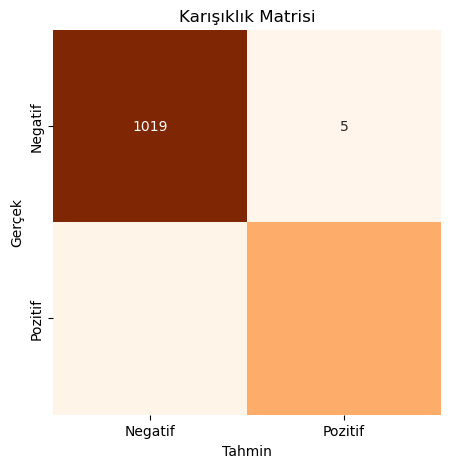

In [303]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False, xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()